In [16]:
# Dependencies
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from PIL import Image
import pandas as pd
from resizeimage import resizeimage
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import pickle
import warnings

# Config
warnings.filterwarnings('ignore')
is_pickled = True
ignore = ['.DS_Store']

In [17]:
# Import Dataset: Class list
classes = [folder for folder in os.listdir('./dataset/') if folder not in ignore]

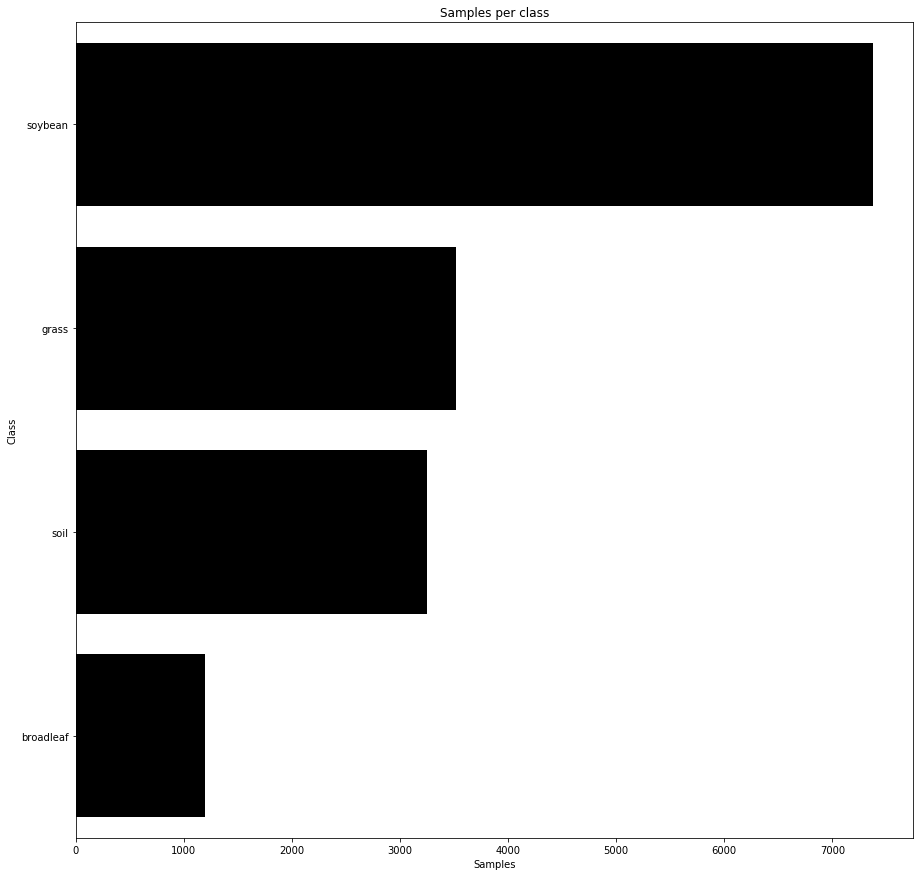

In [18]:
# Import Dataset: Sample image paths
def get_class_img_paths(img_class):
    return ['./dataset/{}/'.format(img_class) + img for img in os.listdir('./dataset/' + img_class) if img not in ignore]

class_img_paths = {}
class_size = {}
for c in classes:
    class_img_paths[c] = get_class_img_paths(c)
    class_size[c] = len(class_img_paths[c])
    
fig = sns.barplot(x = 'val', y = 'cat', data = {'cat': classes, 'val': list(class_size.values())}, color = 'black')
plt.xlabel("Samples")
plt.ylabel("Class")
plt.title("Samples per class")
plt.show(fig)

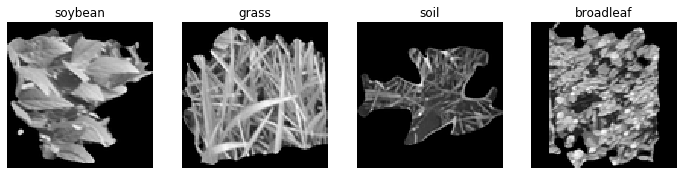

In [19]:
# Display first example in each class
def preprocess_input(img_array):
    img_array /= 255.
    img_array -= 0.5
    img_array *= 2.
    return img_array

def resize(im_array, new_size=[96, 96], mode='contain', bw=True, bg_color=(0, 0, 0, 0), resample=Image.LANCZOS):
    # Proportionally resize image to contain within canvas
    im = Image.fromarray(im_array)
    if mode == 'cover':
        im = resizeimage.resize_cover(im, new_size, resample=resample)
    else:
        im = resizeimage.resize_contain(im, new_size, bg_color=bg_color, resample=resample)
    if bw:
        return np.array(im.convert('LA'))[:,:,0].astype('float')
    
    return np.array(im).astype('float')

fig, ax = plt.subplots(1, len(classes), figsize=(3 * len(classes), 3))
for i in range(len(classes)):
    im = resize(cv2.imread(class_img_paths[classes[i]][0]))

    ax[i].imshow(im, cmap='gray')
    ax[i].set_title(classes[i])
    ax[i].set_axis_off()

In [20]:
# CPU Numpy CNN Layer Implementation
# Source: https://github.com/ahmedfgad/npCNN

mish_math = lambda x: x * np.tanh(np.log1p(np.exp(x))) # Ref: arxiv.org/abs/1908.08681

def conv_(img, conv_filter):
  filter_size = conv_filter.shape[1]
  result = np.zeros((img.shape))
  for r in np.uint16(np.arange(filter_size/2.0,
                               img.shape[0]-filter_size/2.0+1)):
    for c in np.uint16(np.arange(filter_size/2.0,
                                 img.shape[1]-filter_size/2.0+1)):
      curr_region = img[r-np.uint16(np.floor(filter_size/2.0)):r+np.uint16(np.ceil(filter_size/2.0)),
                        c-np.uint16(np.floor(filter_size/2.0)):c+np.uint16(np.ceil(filter_size/2.0))]
      curr_result = curr_region * conv_filter
      conv_sum = np.sum(curr_result)
      result[r, c] = conv_sum

  final_result = result[np.uint16(filter_size/2.0):result.shape[0]-np.uint16(filter_size/2.0),
                        np.uint16(filter_size/2.0):result.shape[1]-np.uint16(filter_size/2.0)]
  return final_result

def conv(img, conv_filter):
  if len(img.shape) != len(conv_filter.shape) - 1:
    print("Error: Number of dimensions in conv filter and image do not match.")
    exit()
  if len(img.shape) > 2 or len(conv_filter.shape) > 3:
    if img.shape[-1] != conv_filter.shape[-1]:
      print("Error: Number of channels in both image and filter must match.")
      sys.exit()
  if conv_filter.shape[1] != conv_filter.shape[2]:
    print('Error: Filter must be a square matrix. I.e. number of rows and columns must match.')
    sys.exit()
  if conv_filter.shape[1] % 2 == 0:
    print('Error: Filter must have an odd size. I.e. number of rows and columns must be odd.')
    sys.exit()

  feature_maps = np.zeros((img.shape[0]-conv_filter.shape[1]+1,
                           img.shape[1]-conv_filter.shape[1]+1,
                           conv_filter.shape[0]))

  for filter_num in range(conv_filter.shape[0]):
    curr_filter = conv_filter[filter_num, :]
    if len(curr_filter.shape) > 2:
      conv_map = conv_(img[:, :, 0], curr_filter[:, :, 0])
      for ch_num in range(1, curr_filter.shape[-1]):
        conv_map = conv_map + conv_(img[:, :, ch_num],
                                    curr_filter[:, :, ch_num])
    else:
      conv_map = conv_(img, curr_filter)
    feature_maps[:, :, filter_num] = conv_map
  return feature_maps

def pooling(feature_map, size=2, stride=2):
  pool_out = np.zeros((np.uint16((feature_map.shape[0]-size+1)/stride+1),
                       np.uint16((feature_map.shape[1]-size+1)/stride+1),
                       feature_map.shape[-1]))
  for map_num in range(feature_map.shape[-1]):
    r2 = 0
    for r in np.arange(0, feature_map.shape[0]-size+1, stride):
      c2 = 0
      for c in np.arange(0, feature_map.shape[1]-size+1, stride):
        pool_out[r2, c2, map_num] = np.max(
            [feature_map[r:r+size,  c:c+size, map_num]])
        c2 = c2 + 1
      r2 = r2 + 1
  return pool_out

def mish(feature_map):
  mish_out = np.zeros(feature_map.shape)
  for map_num in range(feature_map.shape[-1]):
    for r in np.arange(0, feature_map.shape[0]):
      for c in np.arange(0, feature_map.shape[1]):
        mish_out[r, c, map_num] = mish_math(feature_map[r, c, map_num])
  return mish_out

def im_to_cnn_layers(im, preview=False):
    l1_filter = np.zeros((2, 3, 3))
    l1_filter[0, :, :] = np.array([[[-1, 0, 1],
                                    [-1, 0, 1],
                                    [-1, 0, 1]]])
    l1_filter[1, :, :] = np.array([[[1,   1,  1],
                                    [0,   0,  0],
                                    [-1, -1, -1]]])

    l1_feature_map = conv(im, l1_filter)
    l1_feature_map_mish = mish(l1_feature_map)
    l1_feature_map_mish_pool = pooling(l1_feature_map_mish, 2, 2)

    l2_filter = np.random.rand(3, 5, 5, l1_feature_map_mish_pool.shape[-1])
    l2_feature_map = conv(l1_feature_map_mish_pool, l2_filter)
    l2_feature_map_mish = mish(l2_feature_map)
    l2_feature_map_mish_pool = pooling(l2_feature_map_mish, 2, 2)

#     l3_filter = np.random.rand(1, 7, 7, l2_feature_map_mish_pool.shape[-1])
#     l3_feature_map = conv(l2_feature_map_mish_pool, l3_filter)
#     l3_feature_map_mish = mish(l3_feature_map)
#     l3_feature_map_mish_pool = pooling(l3_feature_map_mish, 2, 2)

#     cnn_layers=[im, l1_feature_map_mish_pool[:, :, 0], l2_feature_map_mish_pool[:, :, 0], l3_feature_map_mish_pool[:, :, 0]]

    cnn_layers=[l1_feature_map_mish_pool[:, :, 0], l2_feature_map_mish_pool[:, :, 0]]
    
    if preview:
        fig, ax = plt.subplots(1, 2, figsize=(6, 3))
        for i in range(len(cnn_layers)):
            ax_im = cnn_layers[i]
            ax[i].imshow(ax_im, cmap='gray')
            ax[i].set_axis_off()
    else:
        return np.concatenate([l.flatten() for l in cnn_layers])

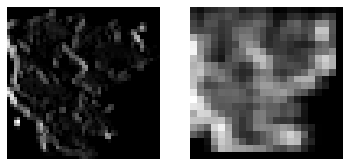

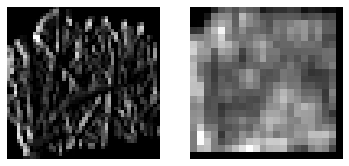

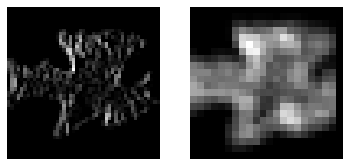

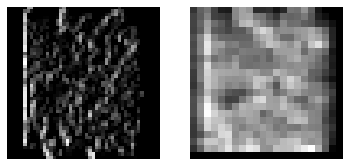

In [21]:
# Preview CNN filters for each class
for c in range(len(classes)):
    im_to_cnn_layers(resize(cv2.imread(class_img_paths[classes[c]][0])), preview=True)

In [22]:
def pickle_save(data, file_path):
    return pickle.dump(data, open(file_path, 'wb'))

def pickle_load(file_path):
    return pickle.load(open(file_path, 'rb'))

# Load dataset into memory
if is_pickled:
    X = pickle_load('./X.p')
    y = pickle_load('./y.p')
else:
    X, y = [], []
    
    for idx, c in enumerate(classes):
        for img_path in tqdm(class_img_paths[c]):
            y.append(idx)

            im = resize(cv2.imread(class_img_paths[classes[idx]][0]))

            # Scale (-1 to +1)
            im = preprocess_input(im)

            # Apply CNN Filters & Flatten to 1D
            im = im_to_cnn_layers(im) # Slow
            X.append(im)
    X, y = np.array(X), np.array(y)
    pickle_save(X, './X.p')
    pickle_save(y, './y.p')

In [23]:
# Simple Training / Validation Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
del X, y

In [24]:
# NN Architecture Implementation
# Source: https://www.kaggle.com/datduyn/2-layer-net-on-weeds-discriminant/

class TwoLayerNet():
    def __init__(self, input_size, hidden_size, output_size, std= 1e-6):
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def loss(self, X, y = None, reg=0.0):
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        layer1 = mish_math(X.dot(W1) + b1)
        scores = mish_math(layer1.dot(W2) + b2)

        if(y is None): 
            return scores

        scores = np.exp(scores - scores.max())
        scores_sumexp = np.sum(scores, axis=1)

        softmax = scores / scores_sumexp.reshape(N,1)
        loss =  (-1.0) * np.sum(np.log(softmax[range(N),y]))
        loss /= N 
        loss += reg * np.sum(W1 * W1) 
        loss += reg * np.sum(W2 * W2) 

        grads = {}

        correct_class_scores = scores[range(N), y]
        softmax[range(N), y] = (-1.0) * (scores_sumexp - correct_class_scores)/scores_sumexp
        softmax /= N

        grads['W2'] = layer1.T.dot(softmax)
        grads['b2'] = np.sum(softmax, axis=0)
        grads['W2'] += reg * 2 * W2
        hidden = softmax.dot(W2.T)
        hidden[layer1 == 0] = 0 

        grads['W1'] = X.T.dot(hidden) 
        grads['b1'] = np.sum(hidden, axis=0)
        grads['W1'] += reg * 2 * W1

        return loss, grads

    def train(self, X, y, X_val, y_val, 
              learning_rate =1e-3, num_iters=5000, learning_rate_decay=0.95,
              reg=0, batch_size=512, it_verbose = 100, verbose=True):

        N, D = X.shape
        N_val = X_val.shape[0]
        iteration_per_epoch = max(N/batch_size, 1)
        
        loss_hist = []
        train_acc_hist = []
        val_acc_hist = []
        
        for it in range(num_iters):
            sampling = np.random.choice(np.arange(N), batch_size, replace=False) 
            X_batch = X[sampling]
            y_batch = y[sampling]
            
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_hist.append(loss) 
            
            self.params['W1'] += (-1.0) * learning_rate * grads['W1']
            self.params['b1'] += (-1.0) * learning_rate * grads['b1']
            self.params['W2'] += (-1.0) * learning_rate * grads['W2']
            self.params['b2'] += (-1.0) * learning_rate * grads['b2']
            
            if(verbose and it%it_verbose==0):
                print('iteration: %d / %d | Loss: %f' % (it, num_iters, loss)) 
            if (it % iteration_per_epoch == 0):
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_hist.append(train_acc)
                val_acc_hist.append(val_acc)
                learning_rate *= learning_rate_decay
        return {
            'loss_hist':loss_hist,
            'train_acc_hist':train_acc_hist,
            'val_acc_hist':val_acc_hist
        }

    def predict(self, X):
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        layer1 = mish_math(X.dot(W1) + b1)
        scores = mish_math(layer1.dot(W2) + b2)

        return np.argmax(scores, axis=1)


In [25]:
# Build Simple NN Model with 2 layers

net = TwoLayerNet(X_train.shape[1], 1024, len(classes))
stats = net.train(X_train, y_train, X_test, y_test)


iteration: 0 / 5000 | Loss: 1.386294
iteration: 100 / 5000 | Loss: 1.372294
iteration: 200 / 5000 | Loss: 0.730917
iteration: 300 / 5000 | Loss: 0.671455
iteration: 400 / 5000 | Loss: 0.601659
iteration: 500 / 5000 | Loss: 0.318132
iteration: 600 / 5000 | Loss: 0.190339
iteration: 700 / 5000 | Loss: 0.091380
iteration: 800 / 5000 | Loss: 0.037790
iteration: 900 / 5000 | Loss: 0.017677
iteration: 1000 / 5000 | Loss: 0.011728
iteration: 1100 / 5000 | Loss: 0.008623
iteration: 1200 / 5000 | Loss: 0.006408
iteration: 1300 / 5000 | Loss: 0.005308
iteration: 1400 / 5000 | Loss: 0.004181
iteration: 1500 / 5000 | Loss: 0.003600
iteration: 1600 / 5000 | Loss: 0.003255
iteration: 1700 / 5000 | Loss: 0.002753
iteration: 1800 / 5000 | Loss: 0.002720
iteration: 1900 / 5000 | Loss: 0.002252
iteration: 2000 / 5000 | Loss: 0.001949
iteration: 2100 / 5000 | Loss: 0.001914
iteration: 2200 / 5000 | Loss: 0.001673
iteration: 2300 / 5000 | Loss: 0.001632
iteration: 2400 / 5000 | Loss: 0.001603
iteration: 2

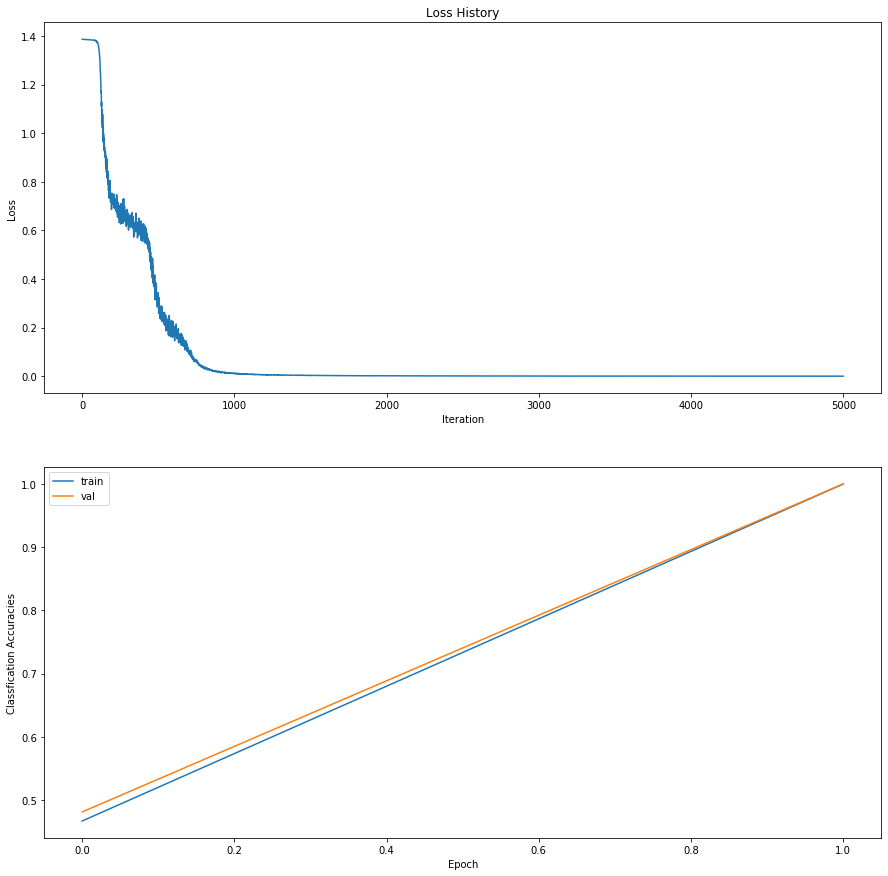

In [26]:
# plot loss history and train/ validation accuracies history
plt.rcParams['figure.figsize'] = (15.0, 15.0) # set default size of plots
plt.subplot(2,1,1) 
plt.plot(stats['loss_hist'])
plt.title('Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2,1,2)
plt.plot(stats['train_acc_hist'], label='train')
plt.plot(stats['val_acc_hist'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Classfication Accuracies')
plt.legend()
plt.show()

In [27]:
vl_score = net.predict(X_test)

print(classification_report(y_test,
                            vl_score,
                            target_names=classes))

              precision    recall  f1-score   support

     soybean       1.00      1.00      1.00      1476
       grass       1.00      1.00      1.00       722
        soil       1.00      1.00      1.00       653
   broadleaf       1.00      1.00      1.00       217

    accuracy                           1.00      3068
   macro avg       1.00      1.00      1.00      3068
weighted avg       1.00      1.00      1.00      3068



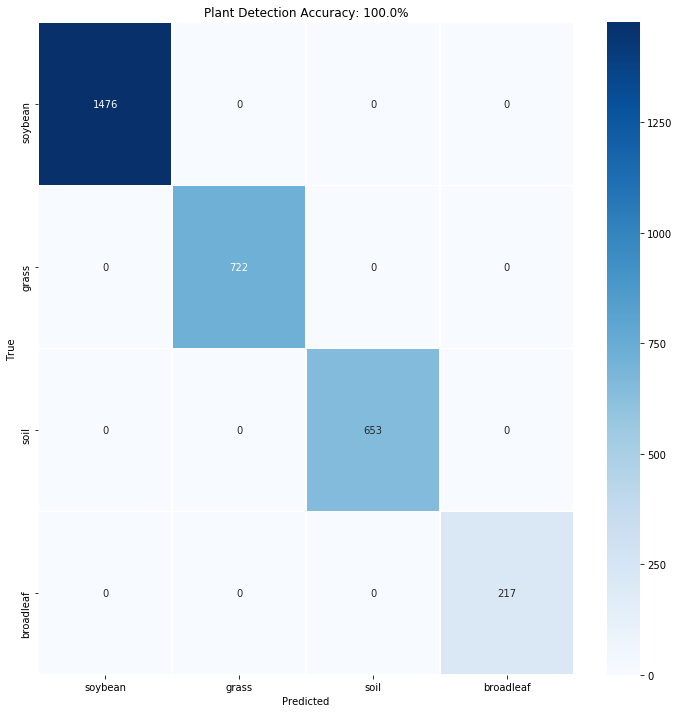

In [28]:
acc = accuracy_score(y_test, vl_score)*100.0
cm = confusion_matrix(y_test, vl_score)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(12,12))
ax = sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g', linewidths=.5)
ax.set_ylim(4.0, 0)
plt.title('Plant Detection Accuracy: {0:.1f}%'.format(acc))
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

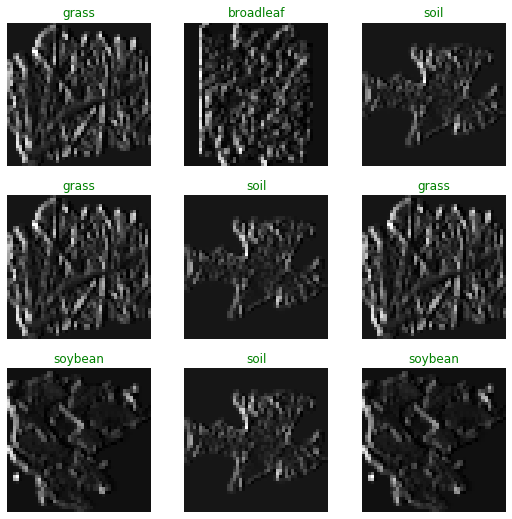

In [29]:
label_CM = {
    0: 'red',  # Incorrect classification
    1: 'green' # Correct classification
}

vl_indices = np.random.choice(len(y_test), 9)
vl_pred = []
vl_true = []

for idx in vl_indices:
    pred = net.predict(np.array([X_test[idx]]))
    vl_true.append(y_test[idx])
    vl_pred.append(pred)
vl_pred = np.array(vl_pred).flatten()

f,ax = plt.subplots(3, 3, figsize=(9, 9))
for idx in range(9):
    score = 1 if vl_pred[idx] == vl_true[idx] else 0
    class_type = classes[y_test[idx]]
    im_data = X_test[idx][0:47 * 47].reshape(47, 47)
    ax[idx//3,idx%3].imshow(im_data, cmap='gray')
    ax[idx//3,idx%3].axis('off')
    ax[idx//3,idx%3].set_title(class_type, color=label_CM[score])